<a href="https://colab.research.google.com/github/sumanbhattarai58/Deeplearning_with_pytorch/blob/main/CNN_cars_classifier_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
#import libraries
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [176]:
#Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
                          ])


In [177]:
#Load train and test datasets
train_dir = "/content/drive/MyDrive/cars_classifier/data/train"
test_dir = "/content/drive/MyDrive/cars_classifier/data/test"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

In [178]:
#Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=10,num_workers=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [179]:
#Verify classes inside folder
print(train_dataset.classes)
print(train_dataset.class_to_idx)

['swift', 'wagonr']
{'swift': 0, 'wagonr': 1}


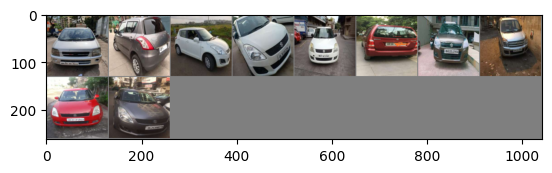

Labels: ['wagonr', 'swift', 'swift', 'swift', 'swift', 'wagonr', 'wagonr', 'wagonr', 'swift', 'swift']


In [180]:
#Visulaize the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5   #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('Labels:', [train_dataset.classes[i] for i in labels])

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim

In [182]:
class CarClassifier(nn.Module):

  def __init__(self, num_classes):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25),

        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout2d(0.25),

      # Third block (optional - remove if still overfitting)
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((4, 4))  # Global average pooling
    )
    self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4*4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
    )

  def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarClassifier(2).to(device)
print(model)

CarClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [184]:
learning_rate = 0.0001
epochs = 150
criteria = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-3)

In [185]:
# Add this before training
print(f"Using device: {device}")
print(f"Model is on: {next(model.parameters()).device}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using device: cuda
Model is on: cuda:0
CUDA available: True


In [171]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False  # Don't stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # Stop if patience exceeded

# Usage in training loop:
early_stopping = EarlyStopping(patience=5)

#training loop
for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criteria(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


  if early_stopping(avg_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch: 1 , Loss: 0.6945585941274961
Epoch: 2 , Loss: 0.6694828439503908
Epoch: 3 , Loss: 0.6500015127162139
Epoch: 4 , Loss: 0.6302862512568633
Epoch: 5 , Loss: 0.6075291591386001
Epoch: 6 , Loss: 0.5803403928875923
Epoch: 7 , Loss: 0.5567544106394052
Epoch: 8 , Loss: 0.5342706508313616
Epoch: 9 , Loss: 0.5163038957243165
Epoch: 10 , Loss: 0.49146191803738476
Epoch: 11 , Loss: 0.47703788423289856
Epoch: 12 , Loss: 0.45059456132973236
Epoch: 13 , Loss: 0.4361340389897426
Epoch: 14 , Loss: 0.4151933210591475
Epoch: 15 , Loss: 0.42713063952202596
Epoch: 16 , Loss: 0.40417256963749726
Epoch: 17 , Loss: 0.3789278416894376
Epoch: 18 , Loss: 0.3712965253119667
Epoch: 19 , Loss: 0.36608786244566244
Epoch: 20 , Loss: 0.3611996163614094
Epoch: 21 , Loss: 0.3578844822011888
Epoch: 22 , Loss: 0.3442191145072381
Epoch: 23 , Loss: 0.3232481111617138
Epoch: 24 , Loss: 0.31831418043002485
Epoch: 25 , Loss: 0.32104442979519565
Epoch: 26 , Loss: 0.2999660348209242
Epoch: 27 , Loss: 0.28605370433069766
E

In [172]:
model.eval()

CarClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): AdaptiveAvgPool2d(output_size=(4, 4))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): 

In [173]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9929166666666667


In [174]:
#evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.88875
